# **Predicting Electricity Spot Prices Based on Weather Patterns and Energy Data**

## **Objective**

The goal of this project is to analyze the relationship between electricity spot prices, weather patterns, and energy production/consumption in Norway from 2017 to 2019. I aim to build predictive models that can forecast electricity prices based on historical data, seasonal trends, and feature engineering.

In [60]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


print("Libaries imported")

Libaries imported


In [61]:
#Loading Data
weather_df = pd.read_csv('/kaggle/input/finland-norway-and-sweden-weather-data-20152019/nordics_weather.csv')
electricity_df = pd.read_csv('/kaggle/input/electricity-spot-price/Elspotprices.csv', delimiter=';')

# List of production and consumption CSV files.
production_consumption_files = ['/kaggle/input/production-and-consumption2017-2019/ProductionConsumption-2017.csv', 
                                '/kaggle/input/production-and-consumption2017-2019/ProductionConsumption-2018.csv', 
                                '/kaggle/input/production-and-consumption2017-2019/ProductionConsumption-2019.csv']

# Read production and comsumption CSV files into dataframes and concatenate them together.
dfs = [pd.read_csv(file, delimiter=';') for file in production_consumption_files]
production_consumption_df = pd.concat(dfs, ignore_index=True)

print("Datasets Loaded")

Datasets Loaded


### **Data Cleaning**

In [62]:
# Convert date/time columns to datetime and set index
weather_df['date'] = pd.to_datetime(weather_df['date'])
weather_df.set_index('date', inplace=True)

electricity_df['HourUTC'] = pd.to_datetime(electricity_df['HourUTC'])
electricity_df.set_index('HourUTC', inplace=True)

production_consumption_df['Time'] = pd.to_datetime(production_consumption_df['Time'])
production_consumption_df.set_index('Time', inplace=True)

# Remove redundant columns in electricity data
electricity_df.drop(columns=['SpotPriceDKK', 'HourDK', 'PriceArea'], inplace=True)


   country      date  precipitation  snow_depth       tavg      tmax  \
0  Finland  1/1/2015       1.714141  284.545455   1.428571  2.912739   
1  Finland  1/2/2015      10.016667  195.000000   0.553571  2.358599   
2  Finland  1/3/2015       3.956061  284.294118  -1.739286  0.820382   
3  Finland  1/4/2015       0.246193  260.772727  -7.035714 -3.110828   
4  Finland  1/5/2015       0.036364  236.900000 -17.164286 -8.727564   

        tmin  
0  -1.015287  
1  -0.998718  
2  -3.463871  
3  -9.502581  
4 -19.004487  
country           object
date              object
precipitation    float64
snow_depth       float64
tavg             float64
tmax             float64
tmin             float64
dtype: object
country          0
date             0
precipitation    0
snow_depth       0
tavg             0
tmax             0
tmin             0
dtype: int64
            HourUTC            HourDK PriceArea SpotPriceDKK  SpotPriceEUR
0  2022-10-19 21:00  2022-10-19 23:00       DK2   978,750000    131

There is an overlaping time period from 2017 to 2019 which will be the time domain for the analysis. I will also filter the weather dataset for Norway specificly to align with the other datasets and merge via 'HourUTC' index.

### **Filter Data (2017-2019)**

In [ ]:
weather_filtered = weather_df[(weather_df.index >= '2017-01-01') & (weather_df.index <= '2019-12-31')]
electricity_filtered = electricity_df[(electricity_df.index >= '2017-01-01') & (electricity_df.index <= '2019-12-31')]
production_consumption_filtered = production_consumption_df[(production_consumption_df.index >= '2017-01-01') & (production_consumption_df.index <= '2019-12-31')]


### **Merge Datasets**

In [66]:
# Merge electricity with weather data
merged_df = pd.merge(electricity_filtered, weather_filtered, left_index=True, right_index=True, how='inner')
# Merge with production/consumption data
merged_df = pd.merge(merged_df, production_consumption_filtered, left_index=True, right_index=True, how='inner')
merged_df.drop_duplicates(inplace=True)

     HourUTC  SpotPriceEUR country  precipitation  snow_depth      tavg  \
0 2019-12-31         21.59  Norway       4.920921  161.163158 -0.666667   
1 2019-12-30         11.84  Norway       7.822269  163.234375  1.757895   
2 2019-12-29         28.10  Norway      19.756303  195.814815  2.657895   
3 2019-12-28         32.32  Norway       9.156303  204.497355 -1.105263   
4 2019-12-27         32.93  Norway       1.078992  202.026042 -4.578947   

       tmax      tmin  Production  Consumption  
0  3.388462 -1.637500       11446        15347  
1  6.254455  1.238614       11231        15318  
2  6.792308  0.575000       13266        16359  
3  2.185000 -5.410680       14896        17849  
4 -1.467308 -7.728155       13386        17300  
HourUTC          datetime64[ns]
SpotPriceEUR            float64
country                  object
precipitation           float64
snow_depth              float64
tavg                    float64
tmax                    float64
tmin                    float64

#Outliers

Due to the nature of spot price and to some extent production and consumption it would be benefitial to look for outliers that could skew the data in futher analysis.


### **Exploratory Data Analysis**

### **Summary Statistics**

In [ ]:
print(merged_df.describe())

In [ ]:
#Visualizations
#Correlation Heatmap
plt.figure(figsize=(10, 8))
corr = merged_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Seasonal Trends
merged_df['Season'] = merged_df.index.month % 12 // 3 + 1
seasonal_means = merged_df.groupby('Season').mean()
seasonal_means[['SpotPriceEUR', 'Production', 'Consumption']].plot(kind='bar', figsize=(10, 6))
plt.title('Seasonal Trends in Spot Prices, Production, and Consumption')
plt.xlabel('Season (1=Winter, 2=Spring, 3=Summer, 4=Fall)')
plt.ylabel('Mean Values')
plt.show()

# Documentation: Analyzing correlations and seasonal trends using heatmaps and bar plots.

### Step 8: Decomposition of Time Series
for col in ['SpotPriceEUR', 'Production', 'Consumption']:
    decomposition = seasonal_decompose(merged_df[col], model='additive', period=365)
    decomposition.plot()
    plt.suptitle(f'Seasonal Decomposition of {col}', fontsize=16)
    plt.show()

# Documentation: Decomposing time-series data to visualize trends, seasonality, and residuals.


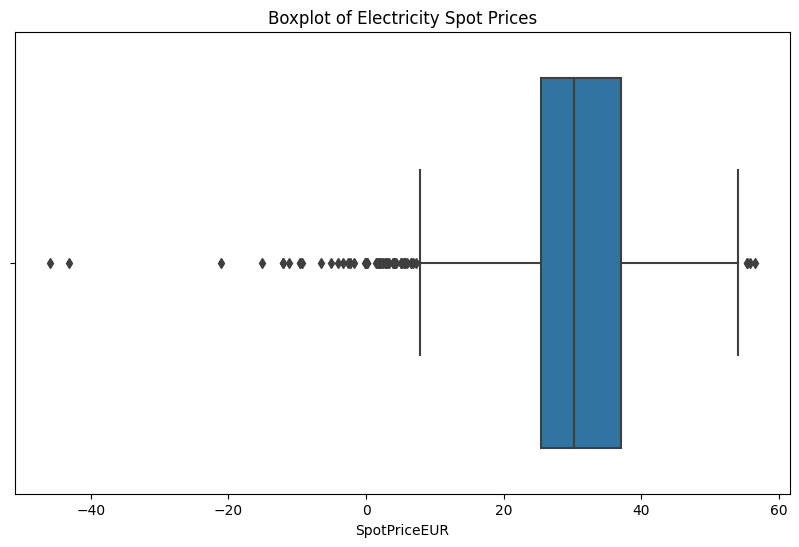

        HourUTC  SpotPriceEUR country  precipitation  snow_depth      tavg  \
16   2019-12-15          1.52  Norway       3.417647  190.433155  0.252632   
20   2019-12-11          2.40  Norway       4.750420  183.941489 -0.515789   
22   2019-12-09        -15.10  Norway       2.627311  182.204188 -4.242105   
24   2019-12-07          4.16  Norway       8.477311  138.629630 -1.984211   
80   2019-10-12         -2.66  Norway       3.358577    3.016760  3.415789   
...         ...           ...     ...            ...         ...       ...   
1040 2017-02-24          0.00  Norway       1.913919  225.442478 -4.642105   
1041 2017-02-23         -5.03  Norway       1.905861  208.116592 -4.463158   
1044 2017-02-20          1.90  Norway       8.589011  162.393805 -1.663158   
1083 2017-01-12          2.76  Norway       4.138686  186.602679 -2.068421   
1091 2017-01-04         -0.05  Norway       0.465201  190.672646 -7.336842   

          tmax      tmin  Production  Consumption  
16    2.662

In [67]:
#Boxplot of Spotprice to check for outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=merged_df['SpotPriceEUR'])
plt.title("Boxplot of Electricity Spot Prices")
plt.show()

#Using IQR to verify the results from the inital Boxpot
Q1 = merged_df['SpotPriceEUR'].quantile(0.25)
Q3 = merged_df['SpotPriceEUR'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = merged_df[(merged_df['SpotPriceEUR'] < lower_bound) | (merged_df['SpotPriceEUR'] > upper_bound)]
print(outliers)

Based on the initial results from the boxplot and IQR. There are some outliers / anomalies that need more investigation. Initially I want to check the negative values in the spot price against the production and consumption values to see if these values are realistic of over production / under consumption or if they are indeed an outliers / anomalies.

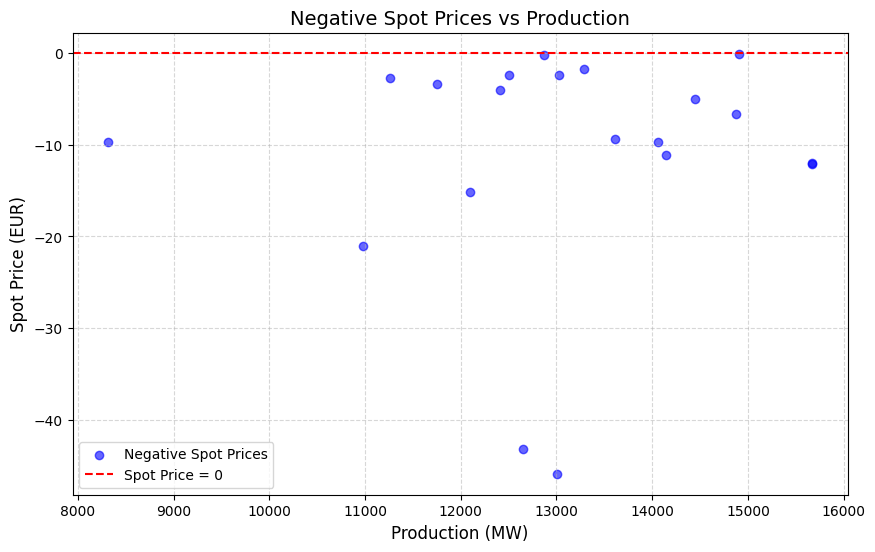

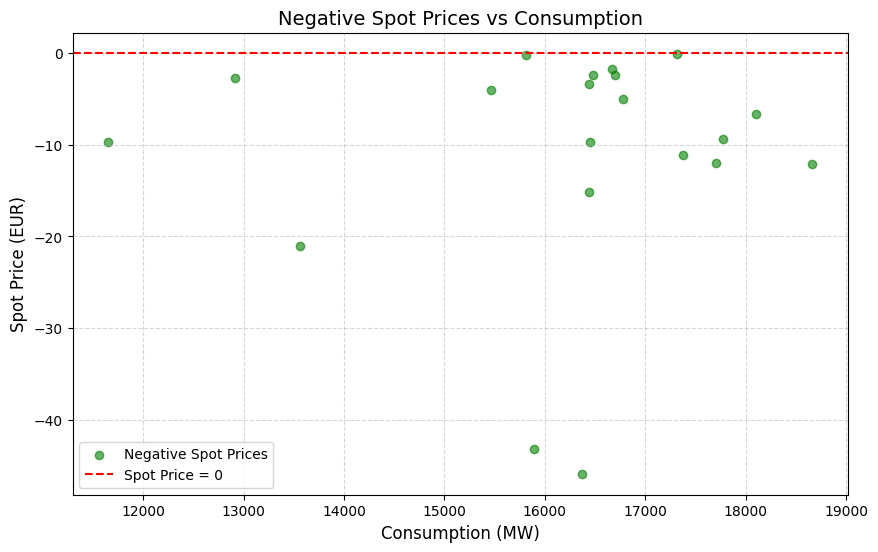

In [68]:
# Filter for negative spot prices
negative_prices = merged_df[merged_df['SpotPriceEUR'] < 0]

# Plot Spot Price vs Production
plt.figure(figsize=(10, 6))
plt.scatter(negative_prices['Production'], negative_prices['SpotPriceEUR'], color='blue', alpha=0.6, label="Negative Spot Prices")
plt.xlabel('Production (MW)', fontsize=12)
plt.ylabel('Spot Price (EUR)', fontsize=12)
plt.title('Negative Spot Prices vs Production', fontsize=14)
plt.axhline(0, color='red', linestyle='--', label='Spot Price = 0')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Plot Spot Price vs Consumption
plt.figure(figsize=(10, 6))
plt.scatter(negative_prices['Consumption'], negative_prices['SpotPriceEUR'], color='green', alpha=0.6, label="Negative Spot Prices")
plt.xlabel('Consumption (MW)', fontsize=12)
plt.ylabel('Spot Price (EUR)', fontsize=12)
plt.title('Negative Spot Prices vs Consumption', fontsize=14)
plt.axhline(0, color='red', linestyle='--', label='Spot Price = 0')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


Spot Price vs. Production:
There is a pattern where the negative spot prices are associated with production levels. These negative prices seem to occur when production is higher. This could indicate an oversupply of electricity, leading to a reduction in prices (potentially even negative values) as producers might be paid to offload excess electricity.

Spot Price vs. Consumption:
However negative spot prices also seem to correlate with higher consumption levels. For both high production and high consumption to be associated with negative spot prices, this does seem unusual. Typically, negative electricity prices can occur when there is an oversupply relative to demand. 

Due to both production and consumption being high and the spot price is still negative, it could indicate a recording error or an anomaly. To get more information I will cross-check the values for both the the production and consumption where these negative prices are reconrded.

In [69]:
# Filtering rows where the spot price is negative
negative_spot_prices = merged_df[merged_df['SpotPriceEUR'] < 0]

# Checking the corresponding production and consumption values
negative_spot_prices[['HourUTC', 'SpotPriceEUR', 'Production', 'Consumption']]


,HourUTC,SpotPriceEUR,Production,Consumption
22,2019-12-09,-15.100000,12098,16439
80,2019-10-12,-2.660000,11257,12914
252,2019-04-23,-9.640000,8312,11647
289,2019-03-17,-3.340000,11755,16440
290,2019-03-16,-2.360000,12504,16478
296,2019-03-10,-11.150000,14140,17375
301,2019-03-05,-2.390000,13031,16694
302,2019-03-04,-0.210000,12869,15817
351,2019-01-14,-9.360000,13614,17775
363,2019-01-02,-45.919998,13009,16373


It is evident that there are multiple instances of negative spot prices recorded alongside varying levels of electricity production and consumption.

Looking at the relationship between these negative spot prices and production/consumption:
For the negative spot price values, the corresponding production and consumption vary widely. Some rows show high levels of production (e.g., 14140 MW production with a spot price of -11.150000 EUR), while others show moderate consumption.

This suggests that the negative spot prices in this dataset may not necessarily be caused by the production or consumption values directly. However, the large discrepancies (such as negative values of -45.919998 EUR) do raise questions about potential data entry errors or anomalies.

Based on the total amount of negative values accounting for a small percetage of the total dataset and the lack of correltation with production and consumption I will remove these values from the analysis.

In [70]:
# Remove rows with negative SpotPriceEUR
cleaned_df = merged_df[merged_df['SpotPriceEUR'] >= 0]

# Calculate the number and percentage of rows removed
removed_rows = len(merged_df) - len(cleaned_df)
percentage_removed = (removed_rows / len(merged_df)) * 100

print(f"Number of rows removed: {removed_rows}")
print(f"Percentage of rows removed: {percentage_removed:.2f}%")
print(f"Cleaned dataset has {len(cleaned_df)} rows.")

# Summary
cleaned_df.describe()

Number of rows removed: 20
Percentage of rows removed: 1.83%
Cleaned dataset has 1075 rows.


,HourUTC,SpotPriceEUR,precipitation,snow_depth,tavg,tmax,tmin,Production,Consumption
count,1075,1075.000000,1075.000000,1075.000000,1075.000000,1075.000000,1075.000000,1075.000000,1075.000000
mean,2018-07-01 12:24:46.883720960,30.957944,3.605142,116.189681,4.367579,8.707746,1.815485,13323.177674,13840.652093
min,2017-01-01 00:00:00,0.000000,0.010317,-0.168539,-9.800000,-5.862963,-13.339623,6660.000000,9609.000000
25%,2017-09-29 12:00:00,25.925000,0.859989,0.052356,-1.189474,2.468997,-3.237578,11151.500000,11064.500000
50%,2018-07-01 00:00:00,30.360001,2.465532,20.106952,3.878947,7.884545,1.593519,12873.000000,13465.000000
75%,2019-04-03 12:00:00,37.244999,5.209303,186.654943,10.607895,15.250728,7.622734,14822.500000,16533.500000
max,2019-12-31 00:00:00,56.470001,21.947368,583.681818,20.258824,27.869903,16.573267,24146.000000,20718.000000
std,NaN,10.914614,3.624965,156.960921,6.663549,7.307516,6.491746,3166.682887,2882.579841


Observations:

Spot Price (SpotPriceEUR):
The range is from 0 to 56.47 EUR, with a mean of 30.96 EUR.
The standard deviation of 10.91 indicates a moderately dispersed distribution.
Potentially interesting to analyze peaks and troughs over time.

Precipitation (precipitation):
The range is from 0.01 to 21.95, with a mean of 3.61.
The high standard deviation (3.62) suggests variable precipitation levels.

Snow Depth (snow_depth):
Highly variable, ranging from -0.17 to 583.68 (mean 116.19).
The high standard deviation (156.96) may indicate seasonal effects.

Temperature (tavg, tmax, tmin):
The mean average temperature is 4.37°C, with an average high of 8.71°C and an average low of 1.82°C.
Temperature ranges look reasonable for seasonal analysis.

Production and Consumption:
Production: Ranges from 6,660 to 24,146 MW, with a mean of 13,323 MW.
Consumption: Ranges from 9,609 to 20,718 MW, with a mean of 13,841 MW.

Both production and consumption have significant variability, suggesting further analysis of their relationship over time.

In [71]:
# Feature importance analysis
from sklearn.ensemble import RandomForestRegressor
X = cleaned_df.drop(columns=['SpotPriceEUR', 'HourUTC'])  # Exclude target and time index
y = cleaned_df['SpotPriceEUR']

rf = RandomForestRegressor(random_state=42)
rf.fit(X, y)
feature_importances = pd.DataFrame(rf.feature_importances_, index=X.columns, columns=['Importance']).sort_values('Importance', ascending=False)
print("Feature Importances:\n", feature_importances)


ValueError: could not convert string to float: 'Norway'

In [ ]:
# Now proceed with the plot code
import seaborn as sns
import matplotlib.pyplot as plt

columns = ['SpotPriceEUR', 'precipitation', 'snow_depth', 'tavg', 'Production', 'Consumption']
for col in columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(cleaned_df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

In [ ]:
# Correlation heatmap
correlation_matrix = cleaned_df[['SpotPriceEUR', 'precipitation', 'snow_depth', 'tavg', 'Production', 'Consumption']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

EDA Observations

Correlation Heatmap
Key Observations:
SpotPriceEUR has weak correlations with all other features.
Production and Consumption are strongly correlated (0.72), as expected.
Temperature (tavg) is strongly negatively correlated with snow depth (-0.73) and consumption (-0.96), indicating higher energy needs during colder months.
Snow depth has moderate positive correlations with Production (0.51) and Consumption (0.76), suggesting its seasonal impact.
Insights:
While the correlations for SpotPriceEUR are weak, other relationships like tavg vs. Consumption and Production vs. Consumption could reveal seasonal or dynamic effects worth exploring futher.

SpotPriceEUR Distribution
Key Observations:
SpotPriceEUR appears approximately normal, but it is slightly skewed to the right.
There are higher frequencies around 25–35 EUR, suggesting a relatively stable price range.
Outliers on both ends (e.g., extremely high and low prices) should be reviewed for potential market anomalies or data recording issues.
Insights:
This distribution suggests SpotPriceEUR is not heavily influenced by extreme events but still has occasional anomalies.

Precipitation Distribution
Key Observations:
Precipitation is positively skewed, with most observations near zero.
A long tail indicates occasional heavy rainfall events.
Insights:
Precipitation’s skewness aligns with natural weather patterns and may be more relevant for seasonal analysis rather than day-to-day electricity prices.

Snow Depth Distribution
Key Observations:
Snow depth is heavily skewed toward low values, with a large concentration around zero.
A small number of extreme snow depth values (e.g., above 300) are likely seasonal and region-specific.
Insights:
Snow depth likely contributes to winter seasonality and increased energy demand for heating, as reflected in correlations with Consumption and Production.

Average Temperature (tavg) Distribution
Key Observations:
The bimodal distribution reflects seasonal changes, with peaks around ~-2°C (winter) and ~10°C (summer).
Extreme cold and warm values are relatively rare.
Insights:
Temperature trends can provide strong signals for energy demand forecasting due to its clear seasonality.

Production Distribution
Key Observations:
Production has a bell-shaped distribution, peaking between ~10,000 and ~15,000 MW.
A few outliers on the high end (~20,000 MW) may represent peak production during extreme energy demand periods.
Insights:
Exploring the relationship between Production and SpotPriceEUR during peak production periods could provide useful insights.

Consumption Distribution
Key Observations:
Consumption has a bimodal pattern, with peaks near 12,000 MW and 17,000 MW.
This could reflect distinct patterns in weekday vs. weekend or seasonal energy usage.
Insights:
The bimodal trend aligns with the seasonality of energy demand, and analyzing SpotPriceEUR during these peaks could reveal interesting market dynamics.

Futher Analysis
Exploring sesonal analysis, time-series visulization of SpotPriceEUR, Production, and Consumption to identify trends and Project Structure

1. Data Collection and Preprocessing

Steps:

Data Sources:

Weather Data: NOAA dataset (2015–2019).

Electricity Spot Prices: Energidataservice.dk.

Energy Production and Consumption: Statnett dataset (2017–2019).

Preprocessing:

Convert all date/time columns to datetime format.

Set datetime columns as the index for time-series alignment.

Merge datasets based on overlapping timeframes (2017–2019).

Cleaning:

Handle missing values using forward-fill imputation for continuity.

Remove extreme outliers using IQR filtering and domain knowledge.

Feature Engineering:

Add lagged features for spot prices, production, and consumption (e.g., lags of 1–3).

Extract seasonal components (Winter, Spring, Summer, Fall) from the timestamp.

Explore feature importance using a Random Forest model to identify key predictors.

Deliverables:

Cleaned and merged dataset ready for analysis.

Code modularized into reusable functions for preprocessing and feature engineering.

2. Exploratory Data Analysis (EDA)

Steps:

Descriptive Statistics:

Summarize data using .describe().

Visualize distributions for key variables (spot prices, production, consumption, weather variables).

Correlation Analysis:

Create a heatmap to identify correlations between variables (e.g., spot prices, weather, production).

Time-Series Plots:

Spot price trends over time.

Production and consumption trends over time.

Seasonal trends in production, consumption, and spot prices.

Seasonal Decomposition:

Decompose spot prices, production, and consumption into trend, seasonal, and residual components using STL decomposition.

Deliverables:

Plots showing trends, seasonality, and correlations.

Markdown explaining key findings and their implications.

3. Modeling and Prediction

Steps:

Define Problem:

Predict electricity spot prices using weather, production, and consumption data.

Baseline Models:

Linear Regression: Start with a simple model to set a baseline.

ARIMA: Add an ARIMA model to leverage time-series dependencies.

Advanced Models:

Random Forest Regressor: Use tree-based models to capture non-linear relationships.

Hyperparameter Tuning: Optimize model parameters using GridSearchCV.

Evaluation Metrics:

Mean Absolute Error (MAE).

Mean Squared Error (MSE).

R-squared score.

Deliverables:

Summary of model performance metrics.

Code modularized into functions for training and evaluation.

4. Visualization and Explainability

Steps:

Model Explainability:

Use SHAP to analyze feature importance and explain predictions.

Visualization:

Actual vs. Predicted Spot Prices: Line plot comparing true and predicted values.

Seasonal Impact Analysis: Show how production, consumption, and weather variables affect spot prices.

Deliverables:

Plots highlighting model explainability and seasonal impacts.

Markdown discussing insights and limitations.

5. Documentation and Finalization

Steps:

Notebook Cleanup:

Organize code into sections with clear headings (e.g., Data Preprocessing, EDA, Modeling).

Add markdown explanations for each section.

GitHub Repository:

Ensure the repository includes:

Cleaned code notebook.

A README.md file explaining the project, methodology, and results.

A requirements.txt file listing dependencies.

Deliverables:

Well-documented Jupyter Notebook.

Updated GitHub repository for public sharing.anomalies.

In [ ]:
# SpotPriceEUR over time
plt.figure(figsize=(14, 6))
plt.plot(cleaned_df['HourUTC'], cleaned_df['SpotPriceEUR'], label='SpotPriceEUR')
plt.title("Electricity Spot Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Spot Price (EUR)")
plt.legend()
plt.show()

# Production and Consumption over time
plt.figure(figsize=(14, 6))
plt.plot(cleaned_df['HourUTC'], cleaned_df['Production'], label='Production', alpha=0.7)
plt.plot(cleaned_df['HourUTC'], cleaned_df['Consumption'], label='Consumption', alpha=0.7)
plt.title("Electricity Production and Consumption Over Time")
plt.xlabel("Date")
plt.ylabel("MW")
plt.legend()
plt.show()


In [ ]:
# Decompose Spot Price EUR
decomposition_spot_price = seasonal_decompose(cleaned_df.set_index('HourUTC')['SpotPriceEUR'], model='additive', period=365)

# Plot the decomposition
decomposition_spot_price.plot()
plt.suptitle('Seasonal Decomposition of Spot Prices', fontsize=16)
plt.show()

# Decompose Production
decomposition_production = seasonal_decompose(cleaned_df.set_index('HourUTC')['Production'], model='additive', period=365)

# Plot the decomposition
decomposition_production.plot()
plt.suptitle('Seasonal Decomposition of Production', fontsize=16)
plt.show()

# Decompose Consumption
decomposition_consumption = seasonal_decompose(cleaned_df.set_index('HourUTC')['Consumption'], model='additive', period=365)

# Plot the decomposition
decomposition_consumption.plot()
plt.suptitle('Seasonal Decomposition of Consumption', fontsize=16)
plt.show()


In [ ]:
# Create lag features for SpotPriceEUR, Production, and Consumption
for lag in range(1, 4):  # Create 1, 2, and 3-hour lags
    cleaned_df[f'SpotPriceEUR_lag{lag}'] = cleaned_df['SpotPriceEUR'].shift(lag)
    cleaned_df[f'Production_lag{lag}'] = cleaned_df['Production'].shift(lag)
    cleaned_df[f'Consumption_lag{lag}'] = cleaned_df['Consumption'].shift(lag)

# Preview the dataframe
print(cleaned_df.head())


In [ ]:
# Define features and target
features = [
    'precipitation', 'snow_depth', 'tavg', 'tmax', 'tmin', 
    'Production', 'Consumption', 
    'SpotPriceEUR_lag1', 'SpotPriceEUR_lag2', 'SpotPriceEUR_lag3',
    'Production_lag1', 'Production_lag2', 'Production_lag3',
    'Consumption_lag1', 'Consumption_lag2', 'Consumption_lag3'
]
X = cleaned_df[features]
y = cleaned_df['SpotPriceEUR']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_model.predict(X_test)
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-squared Score:", r2_score(y_test, y_pred))
